In [1]:
import struct
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import datetime
import glob
import pandas as pd
from itertools import islice  
import xgboost as xgb
from model_config import *
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from scipy import stats
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from treesbo.tuning import main_tuning_with_bo
%matplotlib inline
import matplotlib.pyplot as plt
import joblib


In [2]:
def lblrtm_tape11_reader(fname, opt):
    #%[波数，光学厚度]
    #% File format illustration
    #% for single precision
    #% shift 266*4 bytes
    #% LOOP
    #% 1 int        , 24 (block of v1, v2, dv, npts)
    #% 2 double vars, for v1, and v2
    #% 1 float      , for dv
    #% 1 int        , for npts
    #% 1 int        , 24
    #% 1 int        , 9600 or npts*4 (beg of block output)
    #% NPTs float   , rad
    #% 1 int        , 9600 or npts*4 (end of block of output)
    #% LOOP ENDS
    #
    #% for double precision
    #% shift 356*4 bytes
    #% LOOP
    #% 1 int        , 32 (v1, v2, dv and npts, extra 0)
    #% 3 double vars, for v1, v2, and dv
    #% 1 long int   , for npts
    #% 1 int        , 32   
    #% 1 int        , 19200 or npts*8 (beg of block of output)
    #% NPTS double  , rad
    #% 1 int        , 19200 or npts*8 (end of block of output)
    #% LOOP ENDS
    #%npts: the number of points in the panel?
    #% Author: Xianglei Huang
    #% Tested on Redhat Linux with pgi-compiler version of LBLRTM
    v = np.array([])
    rad = np.array([])
    if opt.lower() == 'float' or opt.lower() == 'single':
        shift = 266
        itype   = 1
    else:
        shift = 356
        itype = 2
    #print(shift,itype)
    fid = open(fname, 'rb')
    fid.seek(shift*4)
    #% decide whether need to open as big-endian file
    test = struct.unpack("i",fid.read(4))[0]  #matlab中的'int'对应c的'int'
    #print("test=",test)
    fid.close()
    if (itype == 1 and test == 24) or (itype ==2 and test == 32):
        fid = open(fname, 'rb')
        fid.seek(shift*4)
        order='<'
    else:
        fid = open(fname, 'rb')
        fid.seek(shift*4)
        order='>'        
    #print(order)
    endflg = 0
    panel = 0
#
    if itype == 1:   
        while endflg == 0:
            panel = panel + 1
            _ = struct.unpack(order+"i",fid.read(4))[0]
            v1= struct.unpack(order+"d",fid.read(8))[0]#matlab的'double'对应c的'double'，对应python的float，占8字节
            #print("v1=",v1)
            if np.isnan(v1):
                break
            v2= struct.unpack(order+"d",fid.read(8))[0]
            #print("v2=",v2)
            dv= struct.unpack(order+"f",fid.read(4))[0]#matlab的'float'对应c的'float'，对应python的float，占4字节
            #print("dv=",dv)
            npts= struct.unpack(order+"i",fid.read(4))[0]
            #print("npts=",npts)
            if npts!=2400:
                endflg=1
                #print("npts break"," and npts=",npts)
            _ = struct.unpack(order+"i",fid.read(4))[0]
            LEN= struct.unpack(order+"i",fid.read(4))[0]
            if LEN!=4*npts:
                #print('1 internal file inconsistency')
                endflg=1
            tmp= struct.unpack(order+str(npts)+"f",fid.read(4*npts))
            #print("tmp=",tmp)
            LEN2= struct.unpack(order+"i",fid.read(4))[0]
            if LEN != LEN2:
                #print('2 internal file inconsistency')
                endflg=1
            v=np.append(v,np.arange(v1,v2,dv).transpose())
            rad=np.append(rad,np.array(tmp).reshape(npts,1))
    else:
        print("itype != 1")
        while endflg == 0:
            panel = panel + 1
            _ = struct.unpack(order+"i",fid.read(4))[0]
            tmp= struct.unpack(order+"3d",fid.read(8*3))
            v1=tmp[0]
            v2=tmp[1]
            dv=tmp[2]
            if np.isnan(v1):
                break 
            npts= struct.unpack(order+"q",fid.read(8))[0] #npts = fread(fid, 1, 'int64');
            if npts!=2400:
                endflg=1
                #print("npts break")
            _ = struct.unpack(order+"i",fid.read(4))[0]   
            LEN= struct.unpack(order+"i",fid.read(4))[0]
            if LEN!=8*npts:
                #print('3 internal file inconsistency')
                endflg=1
            tmp= struct.unpack((order+str(npts)+"d"),fid.read(8*npts))
            LEN2= struct.unpack(order+"i",fid.read(4))[0]
            if LEN != LEN2:
                #print('4 internal file inconsistency')
                endflg=1
            v=np.append(v,np.arange(v1,v2,dv).transpose())
            rad=np.append(rad,np.array(tmp).reshape(npts,1))                
    fid.close()
    return v,rad

In [3]:
def EC(fname):
    p=np.array([])
    t=np.array([])
    wv=np.array([])
    co2=np.array([])
    o3=np.array([])
    no2=np.array([])
    co=np.array([])
    ch4=np.array([])
    input_file=open(fname)
    num=0
    for line in islice(input_file,19,None):
        num=num+1
        #print(line)
        p_temp,t_temp,wv_temp,co2_temp,o3_temp,no2_temp,co_temp,ch4_temp=[float(i) for i in line.split()]
        p=np.append(p,p_temp)
        t=np.append(t,t_temp)
        wv=np.append(wv,wv_temp)
        co2=np.append(co2,co2_temp)
        o3=np.append(o3,o3_temp)
        no2=np.append(no2,no2_temp)
        co=np.append(co,co_temp)
        ch4=np.append(ch4,ch4_temp)
        if num%101==0:
            for line2 in islice(input_file, 0, 2):
                continue
            
    return p,t,wv,co2,o3,no2,co,ch4

In [4]:
def func_evaluation(y_real, y_pred, verbose=True):
    """
    y_real: real values
    y_pred: prediction values
    MAKE THEM HAVE THE SHAPE OF (N,) FIRST BY USING ndarray.ravel()
    """
    if not isinstance(y_real, np.ndarray):
        y_real = np.array(y_real)
    if not isinstance(y_pred, np.ndarray):
        y_pred = np.array(y_pred)
    y_real = y_real.ravel()
    y_pred = y_pred.ravel()

    # MAPE
    def cal_mape(y_true, y_pred):
        y_true = np.where(y_true == 0, 1, y_true)  # To avoid zeros.
        mape = np.mean(abs((y_true.ravel() - y_pred.ravel()) / y_true.ravel()))
        return mape

    m0 = stats.pearsonr(y_real, y_pred)[0]
    m1 = r2_score(y_real, y_pred)
    m2 = explained_variance_score(y_real, y_pred)
    m3 = mean_squared_error(y_real, y_pred)
    m4 = mean_absolute_error(y_real, y_pred)
    m5 = cal_mape(y_real, y_pred)
    if verbose:
        print("模型的评估结果:")
        print(
            'PersonR: %f \nRMSE: %f \nR2: %f \nExplained Variance: %f \nMSE: %f \nMAE: %f \nMAPE: %f'
            % (m0, np.sqrt(m3), m1, m2, m3, m4, m5))
    return m0, np.sqrt(m3), m1, m2, m3, m4, m5



In [5]:
ecpath='/mnt/hdd2/228_data/liuli/liul'
ozopath='/mnt/hdd2/228_data/liuli/liul/ozo/angle1'
ec_name=ecpath+'/ECMWF_83P_101L.dat'
#print(type(test_name))
p,t,wv,co2,o3,no2,co,ch4=EC(ec_name)   
#print(t)
ec_input=np.hstack((p.reshape(-1,1),t.reshape(-1,1),wv.reshape(-1,1),co2.reshape(-1,1),o3.reshape(-1,1),no2.reshape(-1,1),co.reshape(-1,1),ch4.reshape(-1,1)))
print(ec_input.shape)
ec_input_100=np.zeros((83*100,ec_input.shape[1]))
for pro in range(0,83): #83条
    for i in range(0+101*pro,100+101*pro):
        for j in range(ec_input.shape[1]):
            ec_input_100[i-101*pro+100*pro,j]=(ec_input[i,j]+ec_input[i+1,j])/2.0
print(ec_input_100.shape)

(8383, 8)
(8300, 8)


In [6]:
#把EC83的廓线按照第一条，第一层复制55万个，然后第二条、第一层，共83*100*55万个数据。
ec_df=pd.DataFrame(ec_input_100)
#print(ec_df)

true_total=np.array([])
pre_total=np.array([])
for i in range(99,-1,-1):
    f = open("metrics_%d.txt" %(i), "w")
    tot=np.array([])
    v=np.array([])
    mg_od=np.array([])
    for pro in range(0,83):
     #倒叙原因是为与ozo文件统一，ozo中第一层是最底层
        new=np.repeat(ec_df.iloc[i+pro*100].values.reshape(1,-1),555001,axis=0)
        #print(new.shape)
        tot=np.append(tot,new)
        lev=100-i
        #####开始处理ozo的小文件
        fix_name = glob.glob(ozopath+'/*_%dP_*%03d' %(pro+1,lev))
        if os.path.exists(fix_name[0]):
            v_temp,mg_od_temp = lblrtm_tape11_reader(fix_name[0],'single')
            mg_od_temp=np.exp(-mg_od_temp)
            #print("小文件测试",v_temp.shape,mg_od_temp.shape)
            #print(np.where(mg_od_temp==np.max(mg_od_temp)))
            #print(v_temp[22515])
            #fig = plt.figure(figsize=(15,10))
            #ax1 = fig.add_subplot(211)         
            #l1,=ax1.plot(v_temp,mg_od_temp,'g-',linewidth=1.5)
            #ax2 = fig.add_subplot(212)
            #l2,=ax2.plot(mg_od_temp,'r:', linewidth=1.5)
            #plt.show()            
        else:
            v_temp=np.full([555001,], np.nan)
            mg_od_temp=np.full([555001,], np.nan)
        v=np.append(v,v_temp)
        mg_od=np.append(mg_od,mg_od_temp)
    tot=tot.reshape(-1,8)
    v=v.reshape(-1,1)
    
    mg_od=mg_od.reshape(-1,1)
    #print(tot.shape)
    X=np.hstack((tot,v))
    #print(X.shape)
    #print(X)
    Y=mg_od
    #print(Y)
    print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    f.write("start："+datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')+"\n")
    #########开始训练并比较结果
    print("####################！！！LGB Running！！！##########################")
    #best_params, loss=main_tuning_with_bo(
    #X_train=X[:60*555001],
    #y_train=Y[:60*555001].ravel(),
    #X_val=X[60*555001:],
    #y_val=Y[60*555001:].ravel(),
    #model_nm='LGB',
    #max_evals=3,
    #folds=None,
    #nfold=3,
    #eval_metric='l1',
    #task='regression')
    #print(best_params,loss)
    model2 = lgb.LGBMRegressor(**lgbm_params)
    model2.fit(X[:60*555001], Y[:60*555001].ravel())
    #model2 = lgb.LGBMRegressor()
    #gs2 = GridSearchCV(model2, lgbm_grid, cv=3, n_jobs=-1)
    #gs2.fit(X[:60*555001], Y[:60*555001].ravel())
    #print(gs2.best_params_)
    #print(gs2.best_score_)
    #best_model2=gs2.best_estimator_
    y_pred2 = model2.predict(X[60*555001:])
    metrics_i2 = func_evaluation(Y[60*555001:], y_pred2)
    f.write("LGB_finished:"+datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')+"\n")
    f.write(str(lgbm_params))
    f.write(str(metrics_i2)+"\n")
    joblib.dump(model2, 'model_level_%02d.pkl' %(i))
    print("LGB",metrics_i2)
    
    true_total=np.append(true_total,Y[60*555001:])
    pre_total=np.append(pre_total, y_pred2)
    #fig = plt.figure(figsize=(15,10))
    #ax1 = fig.add_subplot(211)         
    #l1,=ax1.plot(X[60*555001:],Y[60*555001:],'g-',linewidth=1.5)
    #l2,=ax1.plot(X[60*555001:],y_pred2,'r:',linewidth=1.5)
    #plt.savefig("OD_plot.png",dpi=100)
    #plt.show()
    

    #print("####################！！！RF Running！！！##########################")
    #best_params3, loss3=main_tuning_with_bo(
    #X[:60*555001],
    #Y[:60*555001].ravel(),
    #model_nm='RF',
    #max_evals=10,
    #folds=None,
    #nfold=3,
    #eval_metric='l2',
    #task='regression')
    #print(best_params3,loss3)
    #model3 = RandomForestRegressor(**best_params3)
    #model3.fit(X[:60*555001], Y[:60*555001].ravel()) 
    #y_pred3 = model3.predict(X[60*555001:])
    #metrics_i3 = func_evaluation(Y[60*555001:], y_pred3)
    #f.write("RF_finished:"+datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')+"\n")
    #f.write(str(best_params3))
    #f.write(str(metrics_i3)+"\n")
    #print("RF",metrics_i3)
    
#
    #print("####################！！！ET Running！！！##########################")
    #model4 = ExtraTreesRegressor(**et_params)
    #model4.fit(X[:60*555001], Y[:60*555001].ravel())
    #y_pred4 = model4.predict(X[60*555001:])
    #metrics_i4 = func_evaluation(Y[60*555001:], y_pred4)
    #f.write(str(datetime.datetime.now())+str(metrics_i4)+"\n")
    #print("ET",metrics_i4) 
    #
#
    #print("####################！！！CAT Running！！！##########################")
    #model5 = CatBoostRegressor(**cat_params,verbose=None)
    #model5.fit(X[:60*555001], Y[:60*555001].ravel())
    #y_pred5 = model5.predict(X[60*555001:])
    #metrics_i5 = func_evaluation(Y[60*555001:], y_pred5)
    #f.write(str(datetime.datetime.now())+str(metrics_i5)+"\n")
    #f.write("end"+datetime.datetime.now()+"\n")
    #print("CAT",metrics_i5) 
    #
#
    #print("####################！！！XGBoost Running！！！##########################")
    #model = xgb.XGBRegressor(**xgb_params)
    #model.fit(X[:60*555001], Y[:60*555001].ravel()) ###共83条廓线，前80条做训练，后3条做测试
    #y_pred = model.predict(X[60*555001:])
    #metrics_i = func_evaluation(Y[60*555001:], y_pred)
    #f.write(str(datetime.datetime.now())+str(metrics_i)+"\n")
    #print("XGB:",metrics_i)
    f.close()
#    if i==99:
#        break



2021-03-25 18:33:49
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.978339 
RMSE: 0.066343 
R2: 0.957114 
Explained Variance: 0.957124 
MSE: 0.004401 
MAE: 0.024419 
MAPE: inf
LGB (0.9783389422719688, 0.06634306823121337, 0.9571140428229776, 0.957124286272274, 0.004401402702331434, 0.024419158328692105, inf)
2021-03-25 18:49:20
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide
/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/numpy/core/_methods.py:160: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


模型的评估结果:
PersonR: 0.977830 
RMSE: 0.067029 
R2: 0.956114 
Explained Variance: 0.956127 
MSE: 0.004493 
MAE: 0.024682 
MAPE: inf
LGB (0.9778300097477911, 0.06702854332107627, 0.9561141905656932, 0.9561268551032931, 0.004492825619745399, 0.024682454289548038, inf)
2021-03-25 19:02:24
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.977296 
RMSE: 0.067715 
R2: 0.955061 
Explained Variance: 0.955084 
MSE: 0.004585 
MAE: 0.025023 
MAPE: inf
LGB (0.9772962583751664, 0.067715145528486, 0.9550609619398516, 0.9550843389553187, 0.004585340933944036, 0.025022767907462065, inf)
2021-03-25 19:15:41
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.976887 
RMSE: 0.068176 
R2: 0.954275 
Explained Variance: 0.954285 
MSE: 0.004648 
MAE: 0.025241 
MAPE: inf
LGB (0.9768868419124923, 0.06817636329900822, 0.9542745980623097, 0.9542846320443474, 0.004648016512678355, 0.02524114025095633, inf)
2021-03-25 19:28:51
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide
/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/numpy/core/_methods.py:160: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


模型的评估结果:
PersonR: 0.976438 
RMSE: 0.068680 
R2: 0.953392 
Explained Variance: 0.953394 
MSE: 0.004717 
MAE: 0.025739 
MAPE: inf
LGB (0.9764382221337287, 0.06868021021274054, 0.9533918811345925, 0.9533935403787901, 0.00471697127486623, 0.025738700446546334, inf)
2021-03-25 19:41:54
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.976264 
RMSE: 0.068679 
R2: 0.953045 
Explained Variance: 0.953061 
MSE: 0.004717 
MAE: 0.024820 
MAPE: inf
LGB (0.9762639307361747, 0.06867943006278156, 0.9530453511440234, 0.9530608974851037, 0.004716864113748503, 0.024819586744274792, inf)
2021-03-25 19:54:56
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.975981 
RMSE: 0.068776 
R2: 0.952501 
Explained Variance: 0.952510 
MSE: 0.004730 
MAE: 0.024753 
MAPE: inf
LGB (0.9759805799466613, 0.06877612722508139, 0.9525007915478437, 0.9525103161878221, 0.004730155676080581, 0.024753278074950036, inf)
2021-03-25 20:07:35
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.975624 
RMSE: 0.068995 
R2: 0.951805 
Explained Variance: 0.951818 
MSE: 0.004760 
MAE: 0.024574 
MAPE: inf
LGB (0.9756241785445913, 0.06899512937506766, 0.951804621270142, 0.9518181130450131, 0.004760327877482324, 0.024573568383977146, inf)
2021-03-25 20:20:20
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.975291 
RMSE: 0.069172 
R2: 0.951156 
Explained Variance: 0.951170 
MSE: 0.004785 
MAE: 0.024461 
MAPE: inf
LGB (0.9752907098432545, 0.0691717700397497, 0.9511562226288623, 0.9511696099787653, 0.004784733770432014, 0.024461262388028888, inf)
2021-03-25 20:33:11
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.975029 
RMSE: 0.069210 
R2: 0.950661 
Explained Variance: 0.950664 
MSE: 0.004790 
MAE: 0.024505 
MAPE: inf
LGB (0.9750287072078773, 0.06920971529565793, 0.9506607143351998, 0.950663971279553, 0.004789984691306028, 0.02450538013125296, inf)
2021-03-25 20:45:52
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide
/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/numpy/core/_methods.py:160: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


模型的评估结果:
PersonR: 0.974779 
RMSE: 0.069229 
R2: 0.950158 
Explained Variance: 0.950176 
MSE: 0.004793 
MAE: 0.023871 
MAPE: inf
LGB (0.9747789147150024, 0.06922850624078304, 0.9501579948948397, 0.950176153339484, 0.004792586076330137, 0.023871002399681505, inf)
2021-03-25 20:58:10
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.974532 
RMSE: 0.069202 
R2: 0.949694 
Explained Variance: 0.949697 
MSE: 0.004789 
MAE: 0.023825 
MAPE: inf
LGB (0.9745321481491244, 0.06920238066841179, 0.9496935239613449, 0.9496968114675337, 0.004788969490175774, 0.02382466242999133, inf)
2021-03-25 21:10:46
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.974314 
RMSE: 0.069129 
R2: 0.949266 
Explained Variance: 0.949277 
MSE: 0.004779 
MAE: 0.023461 
MAPE: inf
LGB (0.9743144220063784, 0.06912896127232604, 0.9492657241649824, 0.9492765735247615, 0.0047788132865907535, 0.023461041977077785, inf)
2021-03-25 21:23:22
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.974115 
RMSE: 0.068996 
R2: 0.948886 
Explained Variance: 0.948886 
MSE: 0.004760 
MAE: 0.023627 
MAPE: inf
LGB (0.9741147171164077, 0.06899570978498176, 0.9488855079108881, 0.9488855577732057, 0.004760407968733427, 0.023626922007552544, inf)
2021-03-25 21:35:48
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.973959 
RMSE: 0.068789 
R2: 0.948584 
Explained Variance: 0.948584 
MSE: 0.004732 
MAE: 0.023622 
MAPE: inf
LGB (0.9739592900409337, 0.06878855112084135, 0.9485844060844416, 0.948584409222033, 0.004731864765304604, 0.023621537562255195, inf)
2021-03-25 21:47:50
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.973948 
RMSE: 0.068386 
R2: 0.948563 
Explained Variance: 0.948564 
MSE: 0.004677 
MAE: 0.022980 
MAPE: inf
LGB (0.973947785927844, 0.06838579119839391, 0.9485625319763243, 0.9485639247212821, 0.00467661643783033, 0.022980022991047323, inf)
2021-03-25 22:00:18
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.973780 
RMSE: 0.068166 
R2: 0.948236 
Explained Variance: 0.948239 
MSE: 0.004647 
MAE: 0.022605 
MAPE: inf
LGB (0.9737798818718575, 0.0681662169555949, 0.9482355484670544, 0.9482392039904832, 0.0046466331340372325, 0.022605100340202217, inf)
2021-03-25 22:12:39
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.973548 
RMSE: 0.068017 
R2: 0.947790 
Explained Variance: 0.947791 
MSE: 0.004626 
MAE: 0.022516 
MAPE: inf
LGB (0.9735482423671514, 0.06801720634422989, 0.9477901648136094, 0.9477905688889029, 0.004626340358873548, 0.022516198084599034, inf)
2021-03-25 22:24:46
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.973345 
RMSE: 0.067817 
R2: 0.947393 
Explained Variance: 0.947395 
MSE: 0.004599 
MAE: 0.022006 
MAPE: inf
LGB (0.9733454995837625, 0.06781724531584672, 0.9473925428237706, 0.9473954344915001, 0.004599178762229735, 0.02200589830091048, inf)
2021-03-25 22:36:49
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.973033 
RMSE: 0.067721 
R2: 0.946787 
Explained Variance: 0.946789 
MSE: 0.004586 
MAE: 0.021915 
MAPE: inf
LGB (0.9730328751566486, 0.06772125739495356, 0.9467869835883316, 0.9467890904360999, 0.004586168703153552, 0.021915037241865522, inf)
2021-03-25 22:48:46
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide
/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/numpy/core/_methods.py:160: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


模型的评估结果:
PersonR: 0.972659 
RMSE: 0.067695 
R2: 0.946060 
Explained Variance: 0.946061 
MSE: 0.004583 
MAE: 0.021808 
MAPE: inf
LGB (0.9726585550836105, 0.06769490878337425, 0.9460601032768646, 0.9460613265790854, 0.00458260067518936, 0.021807589446279172, inf)
2021-03-25 23:00:55
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide
/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/numpy/core/_methods.py:160: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


模型的评估结果:
PersonR: 0.972253 
RMSE: 0.067682 
R2: 0.945272 
Explained Variance: 0.945273 
MSE: 0.004581 
MAE: 0.021715 
MAPE: inf
LGB (0.9722534587897005, 0.06768190534079904, 0.9452720121241177, 0.9452731159060963, 0.004580840310560883, 0.021715487140734516, inf)
2021-03-25 23:12:50
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide
/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/numpy/core/_methods.py:160: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


模型的评估结果:
PersonR: 0.971860 
RMSE: 0.067618 
R2: 0.944504 
Explained Variance: 0.944509 
MSE: 0.004572 
MAE: 0.021491 
MAPE: inf
LGB (0.971860160920578, 0.06761753226933649, 0.9445039447039807, 0.9445085109296778, 0.0045721306701947614, 0.021490823667946923, inf)
2021-03-25 23:24:51
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.971486 
RMSE: 0.067480 
R2: 0.943777 
Explained Variance: 0.943781 
MSE: 0.004554 
MAE: 0.021396 
MAPE: inf
LGB (0.9714856126012723, 0.06747974759369231, 0.9437769632214669, 0.9437812181867414, 0.004553516335308423, 0.0213956773856338, inf)
2021-03-25 23:37:03
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.971062 
RMSE: 0.067373 
R2: 0.942957 
Explained Variance: 0.942958 
MSE: 0.004539 
MAE: 0.021414 
MAPE: inf
LGB (0.9710616867263566, 0.06737305172657017, 0.9429567183782823, 0.9429583317660023, 0.004539128098951099, 0.021413655670161243, inf)
2021-03-25 23:49:05
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide
/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/numpy/core/_methods.py:160: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


模型的评估结果:
PersonR: 0.970551 
RMSE: 0.067348 
R2: 0.941963 
Explained Variance: 0.941966 
MSE: 0.004536 
MAE: 0.021342 
MAPE: inf
LGB (0.9705505299982511, 0.06734802030306167, 0.9419631882172664, 0.9419656847485371, 0.004535755838741607, 0.021341717108013847, inf)
2021-03-26 00:01:18
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide
/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/numpy/core/_methods.py:160: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


模型的评估结果:
PersonR: 0.969971 
RMSE: 0.067355 
R2: 0.940839 
Explained Variance: 0.940842 
MSE: 0.004537 
MAE: 0.021230 
MAPE: inf
LGB (0.9699713486485821, 0.06735533183312267, 0.9408387116096578, 0.9408419833143535, 0.004536740726350068, 0.021229891178566718, inf)
2021-03-26 00:13:35
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.969330 
RMSE: 0.067397 
R2: 0.939597 
Explained Variance: 0.939599 
MSE: 0.004542 
MAE: 0.021231 
MAPE: inf
LGB (0.9693300455893348, 0.06739736563178936, 0.9395966938866305, 0.939598674643312, 0.0045424048941051015, 0.021231218879015194, inf)
2021-03-26 00:25:40
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.968593 
RMSE: 0.067502 
R2: 0.938168 
Explained Variance: 0.938170 
MSE: 0.004557 
MAE: 0.021239 
MAPE: inf
LGB (0.9685925564211294, 0.06750224836522316, 0.9381678186586908, 0.9381698258543024, 0.004556553534360272, 0.02123920908607949, inf)
2021-03-26 00:37:25
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.967778 
RMSE: 0.067638 
R2: 0.936590 
Explained Variance: 0.936593 
MSE: 0.004575 
MAE: 0.021233 
MAPE: inf
LGB (0.9677784645891349, 0.06763799727494217, 0.9365898964342884, 0.936593147262775, 0.004574898675365084, 0.02123282558507868, inf)
2021-03-26 00:48:47
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.966923 
RMSE: 0.067757 
R2: 0.934937 
Explained Variance: 0.934938 
MSE: 0.004591 
MAE: 0.021295 
MAPE: inf
LGB (0.966923043800449, 0.06775698143289054, 0.9349366956271923, 0.9349384410248106, 0.004591008532897073, 0.021294605083349117, inf)
2021-03-26 01:00:34
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.965954 
RMSE: 0.067932 
R2: 0.933063 
Explained Variance: 0.933066 
MSE: 0.004615 
MAE: 0.021239 
MAPE: inf
LGB (0.9659543970057224, 0.06793217296451752, 0.9330628667222126, 0.9330663372333613, 0.004614780123681126, 0.02123922046612534, inf)
2021-03-26 01:12:56
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.964892 
RMSE: 0.068146 
R2: 0.931015 
Explained Variance: 0.931017 
MSE: 0.004644 
MAE: 0.021394 
MAPE: inf
LGB (0.9648924208049686, 0.06814606971842617, 0.9310154794161268, 0.9310165130081437, 0.0046438868180686, 0.021394286785887475, inf)
2021-03-26 01:24:15
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.963642 
RMSE: 0.068467 
R2: 0.928605 
Explained Variance: 0.928606 
MSE: 0.004688 
MAE: 0.021465 
MAPE: inf
LGB (0.9636423224809827, 0.06846662802547217, 0.9286047086298677, 0.9286057732594767, 0.004687679153178371, 0.02146477391486274, inf)
2021-03-26 01:35:38
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide
/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/numpy/core/_methods.py:160: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


模型的评估结果:
PersonR: 0.962244 
RMSE: 0.068862 
R2: 0.925912 
Explained Variance: 0.925913 
MSE: 0.004742 
MAE: 0.021580 
MAPE: inf
LGB (0.9622443896255977, 0.0688616514430431, 0.92591212468641, 0.9259133977127121, 0.00474192703946316, 0.021580223337687592, inf)
2021-03-26 01:46:51
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide
/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/numpy/core/_methods.py:160: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


模型的评估结果:
PersonR: 0.960671 
RMSE: 0.069319 
R2: 0.922888 
Explained Variance: 0.922889 
MSE: 0.004805 
MAE: 0.021695 
MAPE: inf
LGB (0.960671491141849, 0.069319395533748, 0.9228878177424187, 0.9228888969001104, 0.004805178597164202, 0.021695455484745163, inf)
2021-03-26 01:58:40
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide
/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/numpy/core/_methods.py:160: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


模型的评估结果:
PersonR: 0.958974 
RMSE: 0.069796 
R2: 0.919629 
Explained Variance: 0.919630 
MSE: 0.004872 
MAE: 0.021780 
MAPE: inf
LGB (0.9589740633601785, 0.0697963973189524, 0.9196286662600148, 0.9196303640812383, 0.0048715370787050655, 0.021780308780531776, inf)
2021-03-26 02:10:26
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide
/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/numpy/core/_methods.py:160: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


模型的评估结果:
PersonR: 0.957064 
RMSE: 0.070349 
R2: 0.915969 
Explained Variance: 0.915971 
MSE: 0.004949 
MAE: 0.021899 
MAPE: inf
LGB (0.9570640283626202, 0.07034917141238926, 0.9159692461713073, 0.9159708245387979, 0.004949005918409727, 0.02189924531205877, inf)
2021-03-26 02:21:58
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.954876 
RMSE: 0.071015 
R2: 0.911787 
Explained Variance: 0.911788 
MSE: 0.005043 
MAE: 0.022116 
MAPE: inf
LGB (0.9548762849934321, 0.0710148916559014, 0.9117869617626143, 0.911787874912962, 0.005043114836899415, 0.022116201131814752, inf)
2021-03-26 02:33:25
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.952458 
RMSE: 0.071743 
R2: 0.907175 
Explained Variance: 0.907176 
MSE: 0.005147 
MAE: 0.022332 
MAPE: inf
LGB (0.9524582382016664, 0.071743394340545, 0.9071746682731239, 0.9071758140358921, 0.005147114631502943, 0.02233176683643275, inf)
2021-03-26 02:45:03
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.949742 
RMSE: 0.072546 
R2: 0.902008 
Explained Variance: 0.902009 
MSE: 0.005263 
MAE: 0.022609 
MAPE: inf
LGB (0.9497419865979674, 0.07254599220878405, 0.9020081304450013, 0.9020086860054642, 0.005262920985556955, 0.02260856100739529, inf)
2021-03-26 02:56:45
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.946790 
RMSE: 0.073387 
R2: 0.896410 
Explained Variance: 0.896411 
MSE: 0.005386 
MAE: 0.022729 
MAPE: inf
LGB (0.9467904160434092, 0.07338713580088235, 0.8964099955610398, 0.896411032070995, 0.005385671701057149, 0.0227286997561522, inf)
2021-03-26 03:09:56
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide
/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/numpy/core/_methods.py:160: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


模型的评估结果:
PersonR: 0.943446 
RMSE: 0.074332 
R2: 0.890088 
Explained Variance: 0.890089 
MSE: 0.005525 
MAE: 0.023010 
MAPE: inf
LGB (0.9434457303403425, 0.07433198872159076, 0.890087969249678, 0.8900887657266087, 0.005525244547306695, 0.023010438074796462, inf)
2021-03-26 03:21:37
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide
/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/numpy/core/_methods.py:160: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


模型的评估结果:
PersonR: 0.939753 
RMSE: 0.075337 
R2: 0.883133 
Explained Variance: 0.883135 
MSE: 0.005676 
MAE: 0.023239 
MAPE: inf
LGB (0.9397529302364779, 0.0753370695524785, 0.8831334313690787, 0.8831347962991156, 0.005675674048754984, 0.023239116557892875, inf)
2021-03-26 03:33:12
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.935621 
RMSE: 0.076438 
R2: 0.875384 
Explained Variance: 0.875385 
MSE: 0.005843 
MAE: 0.023577 
MAPE: inf
LGB (0.9356208264943058, 0.07643841870410224, 0.8753837221750461, 0.8753848976020677, 0.005842831853983647, 0.02357670201896477, inf)
2021-03-26 03:44:26
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.931018 
RMSE: 0.077627 
R2: 0.866793 
Explained Variance: 0.866794 
MSE: 0.006026 
MAE: 0.023897 
MAPE: inf
LGB (0.9310183019294813, 0.07762676889523978, 0.8667927502342863, 0.8667941245029852, 0.006025915249114966, 0.02389657577313485, inf)
2021-03-26 03:55:21
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.925928 
RMSE: 0.078867 
R2: 0.857341 
Explained Variance: 0.857342 
MSE: 0.006220 
MAE: 0.024314 
MAPE: inf
LGB (0.9259282372808811, 0.07886741629628599, 0.8573409198213995, 0.8573417694145632, 0.006220069353251677, 0.02431426068859238, inf)
2021-03-26 04:06:27
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide
/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/numpy/core/_methods.py:160: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


模型的评估结果:
PersonR: 0.920382 
RMSE: 0.080127 
R2: 0.847101 
Explained Variance: 0.847102 
MSE: 0.006420 
MAE: 0.024711 
MAPE: inf
LGB (0.9203815739133213, 0.08012653701818054, 0.8471008280244028, 0.8471017587712104, 0.006420261934525857, 0.02471139663873746, inf)
2021-03-26 04:17:50
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.914415 
RMSE: 0.081364 
R2: 0.836154 
Explained Variance: 0.836154 
MSE: 0.006620 
MAE: 0.025165 
MAPE: inf
LGB (0.9144151078883568, 0.08136399231909185, 0.8361541896999503, 0.8361543024818705, 0.006620099246101237, 0.02516460866998057, inf)
2021-03-26 04:29:13
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.908110 
RMSE: 0.082526 
R2: 0.824662 
Explained Variance: 0.824662 
MSE: 0.006811 
MAE: 0.025509 
MAPE: inf
LGB (0.9081098063197782, 0.08252621628316588, 0.824662339645527, 0.8246623825909285, 0.006810576374015873, 0.025509464817825393, inf)
2021-03-26 04:40:26
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.901503 
RMSE: 0.083582 
R2: 0.812706 
Explained Variance: 0.812706 
MSE: 0.006986 
MAE: 0.025816 
MAPE: inf
LGB (0.9015026997070537, 0.08358241945670232, 0.8127056238781718, 0.8127056448856455, 0.00698602084223613, 0.025815688429991202, inf)
2021-03-26 04:51:47
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide
/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/numpy/core/_methods.py:160: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


模型的评估结果:
PersonR: 0.894441 
RMSE: 0.084569 
R2: 0.800023 
Explained Variance: 0.800023 
MSE: 0.007152 
MAE: 0.026071 
MAPE: inf
LGB (0.8944409240869159, 0.08456920556793816, 0.8000228951390735, 0.8000229858383795, 0.007151950530392183, 0.02607064347839992, inf)
2021-03-26 05:03:10
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide
/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/numpy/core/_methods.py:160: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


模型的评估结果:
PersonR: 0.887004 
RMSE: 0.085477 
R2: 0.786775 
Explained Variance: 0.786775 
MSE: 0.007306 
MAE: 0.026291 
MAPE: inf
LGB (0.8870041034433279, 0.08547717705507868, 0.7867750753058331, 0.7867751242609244, 0.00730634779730527, 0.026291038597101767, inf)
2021-03-26 05:14:40
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.879123 
RMSE: 0.086315 
R2: 0.772855 
Explained Variance: 0.772855 
MSE: 0.007450 
MAE: 0.026432 
MAPE: inf
LGB (0.8791226503924392, 0.08631506716953567, 0.7728553327389924, 0.7728554233300879, 0.007450290820481455, 0.026432101477097868, inf)
2021-03-26 05:26:38
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide
/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/numpy/core/_methods.py:160: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


模型的评估结果:
PersonR: 0.870793 
RMSE: 0.087063 
R2: 0.758277 
Explained Variance: 0.758279 
MSE: 0.007580 
MAE: 0.026515 
MAPE: inf
LGB (0.8707930129576089, 0.08706257027013724, 0.7582771148231681, 0.7582787114689706, 0.007579891142042584, 0.026515121139069737, inf)
2021-03-26 05:37:57
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.862202 
RMSE: 0.087663 
R2: 0.743390 
Explained Variance: 0.743392 
MSE: 0.007685 
MAE: 0.026529 
MAPE: inf
LGB (0.8622024782622733, 0.08766293491718502, 0.743389800435786, 0.7433916273132526, 0.007684790158294617, 0.02652937526664105, inf)
2021-03-26 05:49:51
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.852983 
RMSE: 0.088220 
R2: 0.727577 
Explained Variance: 0.727578 
MSE: 0.007783 
MAE: 0.026598 
MAPE: inf
LGB (0.8529825499553636, 0.08821999593640167, 0.7275766788105373, 0.7275776845353461, 0.007782767683018727, 0.026597888124044355, inf)
2021-03-26 06:01:46
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide
/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/numpy/core/_methods.py:160: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


模型的评估结果:
PersonR: 0.843296 
RMSE: 0.088707 
R2: 0.711144 
Explained Variance: 0.711146 
MSE: 0.007869 
MAE: 0.026561 
MAPE: inf
LGB (0.8432963595528019, 0.08870667163481914, 0.7111436510129898, 0.7111464527640111, 0.007868873592527626, 0.02656111024541598, inf)
2021-03-26 06:14:11
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.832865 
RMSE: 0.089171 
R2: 0.693660 
Explained Variance: 0.693663 
MSE: 0.007951 
MAE: 0.026664 
MAPE: inf
LGB (0.8328651920317495, 0.08917054974050921, 0.6936598805646056, 0.6936627640275681, 0.007951386941024628, 0.02666385804173831, inf)
2021-03-26 06:25:24
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide
/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/numpy/core/_methods.py:160: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


模型的评估结果:
PersonR: 0.821607 
RMSE: 0.089660 
R2: 0.675035 
Explained Variance: 0.675036 
MSE: 0.008039 
MAE: 0.026903 
MAPE: inf
LGB (0.82160727784592, 0.08965969150976431, 0.6750352473406633, 0.6750364900678156, 0.008038860281626103, 0.02690291402816428, inf)
2021-03-26 06:37:10
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.809902 
RMSE: 0.090055 
R2: 0.655937 
Explained Variance: 0.655939 
MSE: 0.008110 
MAE: 0.027054 
MAPE: inf
LGB (0.8099024223827372, 0.09005517312371179, 0.6559374844150117, 0.6559389133503816, 0.008109934206341703, 0.02705442996585882, inf)
2021-03-26 06:50:02
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.797909 
RMSE: 0.090261 
R2: 0.636654 
Explained Variance: 0.636655 
MSE: 0.008147 
MAE: 0.027102 
MAPE: inf
LGB (0.7979089363090645, 0.09026060018958319, 0.63665411739548, 0.6366551983642819, 0.008146975946583784, 0.027102006722799568, inf)
2021-03-26 07:02:11
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.785739 
RMSE: 0.090286 
R2: 0.617380 
Explained Variance: 0.617382 
MSE: 0.008152 
MAE: 0.026987 
MAPE: inf
LGB (0.7857390491329826, 0.09028567697609059, 0.6173803307531919, 0.6173820151493652, 0.008151503467030976, 0.026986950932681636, inf)
2021-03-26 07:14:14
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.773135 
RMSE: 0.090194 
R2: 0.597734 
Explained Variance: 0.597735 
MSE: 0.008135 
MAE: 0.026881 
MAPE: inf
LGB (0.7731354319244252, 0.09019375663192852, 0.5977339754660628, 0.5977345550021803, 0.00813491373537955, 0.026880796275984126, inf)
2021-03-26 07:26:26
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.760237 
RMSE: 0.090003 
R2: 0.577954 
Explained Variance: 0.577955 
MSE: 0.008100 
MAE: 0.026611 
MAPE: inf
LGB (0.7602372070553596, 0.09000268832522179, 0.5779536197585947, 0.5779554104350753, 0.008100483905767014, 0.026611446119501933, inf)
2021-03-26 07:38:37
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.747064 
RMSE: 0.089673 
R2: 0.558098 
Explained Variance: 0.558099 
MSE: 0.008041 
MAE: 0.026373 
MAPE: inf
LGB (0.7470638858062097, 0.08967267083458537, 0.5580981963143852, 0.5580987301537623, 0.008041187894607898, 0.02637295284927114, inf)
2021-03-26 07:50:57
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide
/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/numpy/core/_methods.py:160: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


模型的评估结果:
PersonR: 0.733766 
RMSE: 0.089194 
R2: 0.538408 
Explained Variance: 0.538408 
MSE: 0.007956 
MAE: 0.026016 
MAPE: inf
LGB (0.7337661210632078, 0.08919378909180886, 0.5384076173673744, 0.5384077035330125, 0.00795553201255408, 0.026015735241447718, inf)
2021-03-26 08:03:11
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.720399 
RMSE: 0.088547 
R2: 0.518970 
Explained Variance: 0.518970 
MSE: 0.007841 
MAE: 0.025589 
MAPE: inf
LGB (0.7203985429522058, 0.08854746319551503, 0.5189696553224568, 0.5189696611400944, 0.007840653238361087, 0.02558925373221008, inf)
2021-03-26 08:15:51
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.707017 
RMSE: 0.087743 
R2: 0.499867 
Explained Variance: 0.499868 
MSE: 0.007699 
MAE: 0.025000 
MAPE: inf
LGB (0.7070174809965032, 0.08774323127049187, 0.49986652688714484, 0.4998680915639805, 0.0076988746337870225, 0.02500003436799136, inf)
2021-03-26 08:28:22
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.693459 
RMSE: 0.086832 
R2: 0.480875 
Explained Variance: 0.480879 
MSE: 0.007540 
MAE: 0.024434 
MAPE: inf
LGB (0.6934592324270944, 0.08683176198093283, 0.4808748069725185, 0.4808791919195964, 0.007539754888713373, 0.024434211890444566, inf)
2021-03-26 08:40:38
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.680052 
RMSE: 0.085746 
R2: 0.462452 
Explained Variance: 0.462462 
MSE: 0.007352 
MAE: 0.023718 
MAPE: inf
LGB (0.6800519123371663, 0.08574600286033107, 0.46245213370568217, 0.46246246047779627, 0.007352377006523905, 0.023718208066571086, inf)
2021-03-26 08:53:10
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.666984 
RMSE: 0.084479 
R2: 0.444855 
Explained Variance: 0.444861 
MSE: 0.007137 
MAE: 0.023068 
MAPE: inf
LGB (0.6669843406327567, 0.08447946655307324, 0.44485501060575894, 0.44486108728593843, 0.0071367802690918206, 0.023067752824891975, inf)
2021-03-26 09:05:30
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.654418 
RMSE: 0.083025 
R2: 0.428257 
Explained Variance: 0.428258 
MSE: 0.006893 
MAE: 0.022392 
MAPE: inf
LGB (0.6544180304263754, 0.0830250877510605, 0.428257122930364, 0.42825776144915184, 0.006893165196071297, 0.022391530421844174, inf)
2021-03-26 09:18:27
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.642252 
RMSE: 0.081481 
R2: 0.412476 
Explained Variance: 0.412481 
MSE: 0.006639 
MAE: 0.021486 
MAPE: inf
LGB (0.6422522345262974, 0.08148068223631738, 0.41247609288955256, 0.41248081984922114, 0.006639101577695727, 0.02148639955533175, inf)
2021-03-26 09:31:13
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.630281 
RMSE: 0.079852 
R2: 0.397251 
Explained Variance: 0.397251 
MSE: 0.006376 
MAE: 0.020791 
MAPE: inf
LGB (0.6302814791498562, 0.07985192020099843, 0.39725110091410887, 0.3972511060065498, 0.0063763291597866215, 0.02079080180213368, inf)
2021-03-26 09:43:59
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.618645 
RMSE: 0.078157 
R2: 0.382718 
Explained Variance: 0.382718 
MSE: 0.006109 
MAE: 0.019988 
MAPE: inf
LGB (0.6186447268977846, 0.07815721169155121, 0.38271798719685, 0.38271802815220535, 0.006108549739397949, 0.01998845730987525, inf)
2021-03-26 09:56:31
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.607417 
RMSE: 0.076350 
R2: 0.368952 
Explained Variance: 0.368952 
MSE: 0.005829 
MAE: 0.019145 
MAPE: inf
LGB (0.6074167708866905, 0.0763504128552453, 0.3689519100444155, 0.3689520587867958, 0.005829385543166405, 0.01914527722729173, inf)
2021-03-26 10:09:45
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.596701 
RMSE: 0.074405 
R2: 0.356049 
Explained Variance: 0.356049 
MSE: 0.005536 
MAE: 0.018289 
MAPE: inf
LGB (0.5967006310983543, 0.07440539719543311, 0.35604869216616997, 0.3560494839195393, 0.005536163131810166, 0.018288954412535533, inf)
2021-03-26 10:23:02
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.586889 
RMSE: 0.072218 
R2: 0.344435 
Explained Variance: 0.344435 
MSE: 0.005215 
MAE: 0.017270 
MAPE: inf
LGB (0.5868888260316272, 0.07221823507685599, 0.344435406963876, 0.34443543406663235, 0.005215473477616032, 0.017269708167320173, inf)
2021-03-26 10:35:54
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.577900 
RMSE: 0.069767 
R2: 0.333966 
Explained Variance: 0.333966 
MSE: 0.004867 
MAE: 0.016242 
MAPE: inf
LGB (0.5779003593955797, 0.0697665449730007, 0.3339658793206923, 0.33396648930555506, 0.004867370797469728, 0.01624247143422345, inf)
2021-03-26 10:48:14
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.569370 
RMSE: 0.067083 
R2: 0.324181 
Explained Variance: 0.324181 
MSE: 0.004500 
MAE: 0.015126 
MAPE: inf
LGB (0.5693704238648191, 0.06708342808931497, 0.32418086143651137, 0.32418144844991503, 0.004500186324214293, 0.01512616331825814, inf)
2021-03-26 11:00:48
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.560582 
RMSE: 0.064211 
R2: 0.314251 
Explained Variance: 0.314251 
MSE: 0.004123 
MAE: 0.013952 
MAPE: inf
LGB (0.5605823903430917, 0.06421121831024364, 0.3142509385517551, 0.3142511802786111, 0.004123080556885767, 0.013951761735974273, inf)
2021-03-26 11:13:07
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.550654 
RMSE: 0.061251 
R2: 0.303217 
Explained Variance: 0.303218 
MSE: 0.003752 
MAE: 0.012794 
MAPE: inf
LGB (0.5506535062769706, 0.06125064395224934, 0.3032174147189505, 0.30321755222665236, 0.0037516413845652186, 0.012794406235264932, inf)
2021-03-26 11:25:34
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.538713 
RMSE: 0.058196 
R2: 0.290209 
Explained Variance: 0.290209 
MSE: 0.003387 
MAE: 0.011628 
MAPE: inf
LGB (0.5387127400166082, 0.05819623057424114, 0.2902086820209958, 0.29020868456723425, 0.0033868012530502392, 0.011627781412334417, inf)
2021-03-26 11:38:01
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.524146 
RMSE: 0.054997 
R2: 0.274727 
Explained Variance: 0.274727 
MSE: 0.003025 
MAE: 0.010481 
MAPE: inf
LGB (0.5241461946637546, 0.05499700019134243, 0.27472676439712196, 0.27472677378503907, 0.0030246700300465197, 0.010481028019915257, inf)
2021-03-26 11:50:32
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.506808 
RMSE: 0.051695 
R2: 0.256852 
Explained Variance: 0.256852 
MSE: 0.002672 
MAE: 0.009363 
MAPE: inf
LGB (0.5068083062249457, 0.05169475769190085, 0.2568517782564468, 0.2568518803634955, 0.002672347972824342, 0.00936336176521601, inf)
2021-03-26 12:02:52
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.486033 
RMSE: 0.048338 
R2: 0.236225 
Explained Variance: 0.236226 
MSE: 0.002337 
MAE: 0.008261 
MAPE: inf
LGB (0.48603337537715907, 0.048338164995239324, 0.23622542552033432, 0.23622574604930713, 0.0023365781951069802, 0.008260975236710072, inf)
2021-03-26 12:15:57
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.461418 
RMSE: 0.044991 
R2: 0.212903 
Explained Variance: 0.212903 
MSE: 0.002024 
MAE: 0.007201 
MAPE: inf
LGB (0.461417811244018, 0.04499062687115018, 0.21290270616688856, 0.212902945282072, 0.0020241565062590603, 0.0072007144266726785, inf)
2021-03-26 12:28:12
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.433260 
RMSE: 0.041771 
R2: 0.187710 
Explained Variance: 0.187711 
MSE: 0.001745 
MAE: 0.006221 
MAPE: inf
LGB (0.43326046903937776, 0.04177065904124514, 0.18771037756550268, 0.18771055044586704, 0.0017447879567399542, 0.006221139128306391, inf)
2021-03-26 12:40:02
####################！！！LGB Running！！！##########################


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.401583 
RMSE: 0.038707 
R2: 0.161263 
Explained Variance: 0.161263 
MSE: 0.001498 
MAE: 0.005310 
MAPE: inf
LGB (0.40158264213122213, 0.038707051741716944, 0.1612629725860828, 0.16126298351974844, 0.0014982358545359527, 0.005310124414490403, inf)
2021-03-26 12:52:39
####################！！！LGB Running！！！##########################
模型的评估结果:
PersonR: 0.367766 
RMSE: 0.035889 
R2: 0.135243 
Explained Variance: 0.135243 
MSE: 0.001288 
MAE: 0.004514 
MAPE: 22224299428285609451717225429796231058019299918334936535427575797257472052258094824662426670360232246009575335695417075898243617735130507978011638912965392905771101700944750361770424297208909132252267242339677557275903583111601982556888890691518448922393719552113865832529920.000000
LGB (0.36776581437308004, 0.03588926853496963, 0.13524332541952622, 0.13524338528595659, 0.0012880395959751615, 0.004513890407439057, 2.222429942828561e+274)
2021-03-26 13:04:37
####################！！！LGB Running！！！##########################


In [7]:
np.savez('pre.npz', sequence_array=pre_total)
np.savez('tru.npz', sequence_array=true_total)
metrics_total = func_evaluation(true_total, pre_total)
print(metrics_total)

/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in true_divide


模型的评估结果:
PersonR: 0.945891 
RMSE: 0.070713 
R2: 0.894701 
Explained Variance: 0.894702 
MSE: 0.005000 
MAE: 0.019986 
MAPE: inf
(0.9458910960878036, 0.07071313997647734, 0.8947007067936396, 0.8947023324473464, 0.005000348165332877, 0.019986359688119928, inf)


/mnt/hdd3/liuli/anaconda3/envs/JT/lib/python3.7/site-packages/numpy/core/_methods.py:160: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


(1276502300,) (1276502300,)
0.019986359688119928


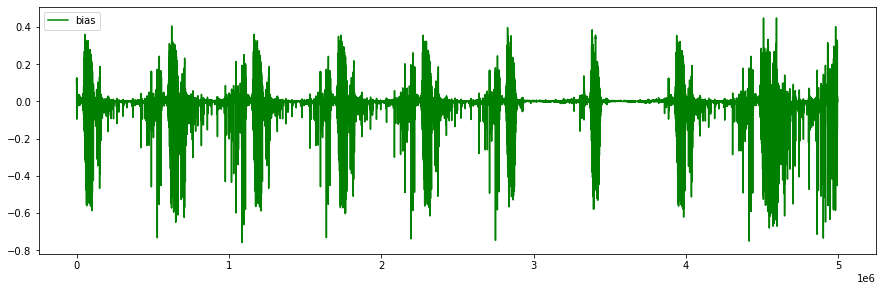

In [22]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)  
print(true_total.shape,pre_total.shape)
print(np.mean(abs(true_total.ravel()-pre_total.ravel())))
l1,=ax1.plot(true_total[190*555001:199*555001].ravel()-pre_total[190*555001:199*555001].ravel(),'g-',linewidth=1.5)
plt.legend(["bias"])
#plt.savefig("OD_plot.png",dpi=100)
plt.show()

In [9]:
#取出第一层的数据，即前（55万个*83条）条数据

In [10]:
##fixpath='/home/liuli/liul/fixgas/angle1'
#
##ßwvpath='/home/liuli/liul/wv/angle1'
#
#for lev in range(1,2):#101):
##    print(pro)  
#    for pro in range(1,2): #84):
#        fix_name = glob.glob(ozopath+'/*_%dP_*%03d' %(pro,lev))
#        if os.path.exists(fix_name[0]):
#            print(fix_name[0])
#            v_temp,mg_od_temp = lblrtm_tape11_reader(fix_name[0],'single')
#            
#        else:
#            v=np.full([555001,], np.nan)
#            mg_od=np.full([555001,], np.nan)
#        v=np.append(v,v_temp)
#        #print(v.shape)
#        mg_od=np.append(mg_od,mg_od_temp)
#print(v.shape,mg_od.shape)
##np.savez('v.npz', sequence_array=v)
##np.savez('mg_od.npz', sequence_array=mg_od)